In [1]:
# ---- IMPORTS ----
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math as m
import os
%matplotlib inline

In [2]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
def dist (alist = []):
    distance = m.sqrt(m.pow((alist[2]-alist[0]),2)+m.pow((alist[3]-alist[1]),2))
    return distance

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


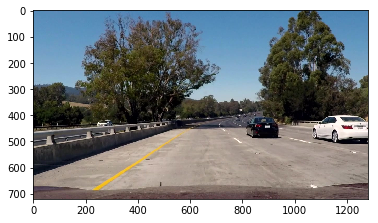

In [4]:
# ---- READ IMAGE ----
image1 = mpimg.imread('challenge/challenge 125.jpg')
print('This image is:', type(image1), 'with dimensions:', image1.shape)
image = np.copy(image1)
plt.imshow(image)

In [5]:
# Color Selection
# choose only yellow and white, make everything else dark
r_th = 200
g_th = 200
b_th = 0
thresholds = (image[:,:,0] < r_th) & (image[:,:,1] < g_th) #| (image[:,:,2] < b_th)
image[thresholds] = [0,0,0]

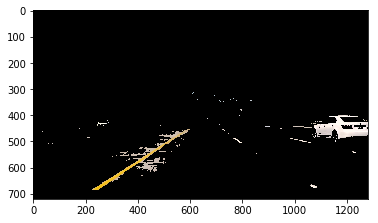

In [6]:
plt.imshow(image)

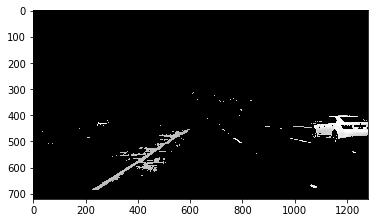

In [7]:
# ---- GRAY SCALE ----
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [8]:
# ---- GAUSSIAN SMOOTHING ----
window_size = 5
blur_gray = cv2.GaussianBlur(gray,(window_size, window_size), 0)
#plt.imshow(blur_gray,cmap='gray')

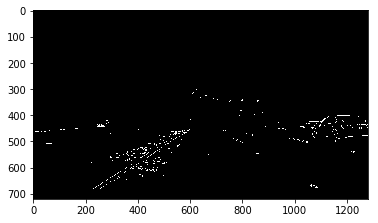

In [9]:
# ---- CANNY EDGE DETECTION ----
high_threshold = 140
low_threshold = 35
canny_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(canny_edges,cmap='gray')

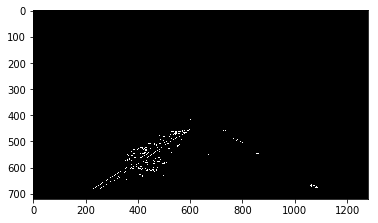

In [10]:
# ---- AREA SELECTION ----
selected_area = np.zeros_like(canny_edges)   
selected_area_color = 255 
x_max = image.shape[1]
y_max = image.shape[0]
vertices = np.array([[((x_max/2)-5,(y_max/2)+30),((x_max/2)+5,(y_max/2)+30),(x_max-50,y_max),(50,y_max)]], dtype=np.int32)
cv2.fillPoly(selected_area, vertices, selected_area_color)
masked_canny_edges = cv2.bitwise_and(canny_edges, selected_area)
plt.imshow(masked_canny_edges,cmap='gray')

In [11]:
# ---- HOUGH TRANSFORM LINE DETECTION ----
rho = 1 
theta = np.pi/180 
threshold = 20 
min_line_length = 10 
max_line_gap = 8
hough_lines = cv2.HoughLinesP(masked_canny_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
hough_lines_image = np.copy(image)*0
#first interpolate/average, then draw

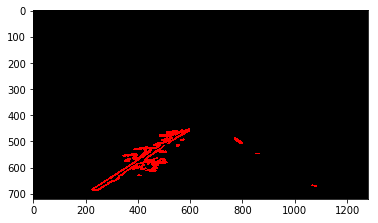

In [12]:
#Temp: only to display intermediate result
hough_lines_image_temp = np.copy(image)*0
for line in hough_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(hough_lines_image_temp, (x1,y1),(x2,y2),(255,0,0),5)

plt.imshow(hough_lines_image_temp)

In [13]:
hough_lines_with_slopes = []
for line in hough_lines:
    for x1,y1,x2,y2 in line:
        slope = (y2-y1)/(x2-x1)
        hough_lines_with_slopes.append([x1,y1,x2,y2,slope])

In [14]:
# delete lines with slopes close to zero

In [15]:
slope_positive = []
slope_negative = []
slope_zero = []
for item in hough_lines_with_slopes:
    if item[4] > 0.4:
        slope_positive.append(item)
    elif item[4] < -0.4:
        slope_negative.append(item)
    else:
        slope_zero.append(item)     # remove lines with slopes close to zero  

In [16]:
# delete right lines which have very different slope than the longest line
right_line_lengths = []
indices_to_delete_right = []
for line in slope_positive:
    right_line_lengths.append(dist(line))
idx = right_line_lengths.index(max(right_line_lengths))
opt_slope = slope_positive[idx][4]
for i in range(len(slope_positive)):
    if abs((slope_positive[i][4]-opt_slope)*2*100/(slope_positive[i][4]+opt_slope))>10:
        indices_to_delete_right.append(i)
        
slope_positive = [i for j, i in enumerate(slope_positive) if j not in indices_to_delete_right]

In [17]:
# delete left lines which have very different slope than the longest line
left_line_lengths = []
indices_to_delete_left = []
for line in slope_negative:
    left_line_lengths.append(dist(line))
idx = left_line_lengths.index(max(left_line_lengths))
opt_slope = slope_negative[idx][4]
for i in range(len(slope_negative)):
    if abs((slope_negative[i][4]-opt_slope)*2*100/(slope_negative[i][4]+opt_slope))>10:
        indices_to_delete_left.append(i)
        
slope_negative = [i for j, i in enumerate(slope_negative) if j not in indices_to_delete_left]

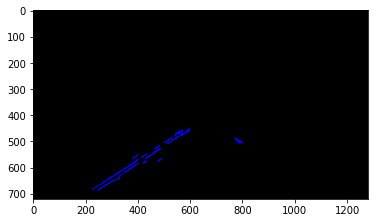

In [18]:
dumm_image = np.copy(image)*0
for line in slope_positive:
    cv2.line(dumm_image, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])),[0,0,255], 4)
for line in slope_negative:
    cv2.line(dumm_image, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])),[0,0,255], 4)    
plt.imshow(dumm_image)

___average lines with negative slope (left)___

In [19]:
left_lines = []
if len(slope_negative) == 2:
    x1=(slope_negative[0][0]+slope_negative[1][0])/2
    y1=(slope_negative[0][1]+slope_negative[1][1])/2
    x2=(slope_negative[0][2]+slope_negative[1][2])/2
    y2=(slope_negative[0][3]+slope_negative[1][3])/2
    left_lines.append([x1,y1,x2,y2])
else:
    #list has P1(x1,y1) and P2(x2,y2) for all lines. We search for the P1 with smallest y1 and P2 with largest y2 and combine 
    #them to create a single line. Note: P1, P2 are not in any order
    smallest_y1 = min(slope_negative,key=lambda x: x[1])
    smallest_y2 = min(slope_negative,key=lambda x: x[3])
    if(smallest_y1[1]<smallest_y2[3]):
        p1a_x = smallest_y1[0]
        p1a_y = smallest_y1[1]
    else:
        p1a_x = smallest_y2[2]
        p1a_y = smallest_y2[3]
    
    largest_x1 = max(slope_negative,key=lambda x: x[0])
    largest_x2 = max(slope_negative,key=lambda x: x[2])
    if(largest_x1[0]>largest_x2[2]):
        p1b_x = largest_x1[0]
        p1b_y = largest_x1[1]
    else:
        p1b_x = largest_x2[2]
        p1b_y = largest_x2[3]
    
    p1_x = (p1a_x+p1b_x)/2
    p1_y = (p1a_y+p1b_y)/2
        
    #--------------------------------------        
    largest_y1 = max(slope_negative,key=lambda x: x[1])
    largest_y2 = max(slope_negative,key=lambda x: x[3])
    if(largest_y1[1]>largest_y2[3]):
        p2a_x = largest_y1[0]
        p2a_y = largest_y1[1]
    else:
        p2a_x = largest_y2[2]
        p2a_y = largest_y2[3]
        
    smallest_x1 = min(slope_negative,key=lambda x: x[0])
    smallest_x2 = min(slope_negative,key=lambda x: x[2])
    if(smallest_x1[0]<smallest_x2[2]):
        p2b_x = smallest_x1[0]
        p2b_y = smallest_x1[1]
    else:
        p2b_x = smallest_x2[2]
        p2b_y = smallest_x2[3]
   
    p2_x = (p2a_x+p2b_x)/2
    p2_y = (p2a_y+p2b_y)/2
        
    left_lines.append([p1_x,p1_y,p2_x,p2_y])  

___average lines with positive slopes (right)___

In [20]:
right_lines = []
if len(slope_positive) == 2:
    x1=(slope_positive[0][0]+slope_positive[1][0])/2
    y1=(slope_positive[0][1]+slope_positive[1][1])/2
    x2=(slope_positive[0][2]+slope_positive[1][2])/2
    y2=(slope_positive[0][3]+slope_positive[1][3])/2
    right_lines.append([x1,y1,x2,y2])
else:
    #list has P1(x1,y1) and P2(x2,y2) for all lines. We search for the P1 with smallest y1 and P2 with largest y2 and combine 
    #them to create a single line
    smallest_y1 = min(slope_positive,key=lambda x: x[1])
    smallest_y2 = min(slope_positive,key=lambda x: x[3])
    if(smallest_y1[1]<smallest_y2[3]):
        p1a_x = smallest_y1[0]
        p1a_y = smallest_y1[1]
    else:
        p1a_x = smallest_y2[2]
        p1a_y = smallest_y2[3]
    
    smallest_x1 = min(slope_positive,key=lambda x: x[0])
    smallest_x2 = min(slope_positive,key=lambda x: x[2])
    if(smallest_x1[0]<smallest_x2[2]):
        p1b_x = smallest_x1[0]
        p1b_y = smallest_x1[1]
    else:
        p1b_x = smallest_x2[2]
        p1b_y = smallest_x2[3]
        
    p1_x = (p1a_x+p1b_x)/2
    p1_y = (p1a_y+p1b_y)/2
    #--------------------------------------            
    largest_y1 = max(slope_positive,key=lambda x: x[1])
    largest_y2 = max(slope_positive,key=lambda x: x[3])
    if(largest_y1[1]>largest_y2[3]):
        p2a_x = largest_y1[0]
        p2a_y = largest_y1[1]
    else:
        p2a_x = largest_y2[2]
        p2a_y = largest_y2[3]
        
    largest_x1 = max(slope_positive,key=lambda x: x[0])
    largest_x2 = max(slope_positive,key=lambda x: x[2])
    if(largest_x1[0]>largest_x2[2]):
        p2b_x = largest_x1[0]
        p2b_y = largest_x1[1]
    else:
        p2b_x = largest_x2[2]
        p2b_y = largest_x2[3]
        
    p2_x = (p2a_x+p2b_x)/2
    p2_y = (p2a_y+p2b_y)/2
        
    right_lines.append([p1_x,p1_y,p2_x,p2_y])  

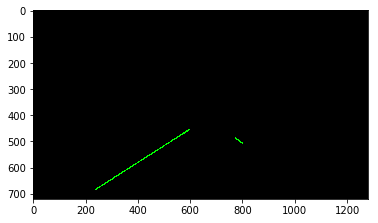

In [21]:
lines = left_lines + right_lines
dummy_image = np.copy(image)*0
for line in lines:
    cv2.line(dummy_image, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])),[0,255,0], 4) 
plt.imshow(dummy_image)

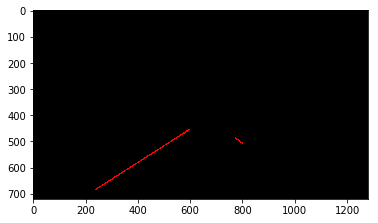

In [22]:
for line in lines:
    cv2.line(hough_lines_image, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])),[255,0,0], 4) 
plt.imshow(hough_lines_image)

In [23]:
#Extrapolation
#extrapolate lines[0]
x1 = lines[0][0]
y1 = lines[0][1]
x2 = lines[0][2]
y2 = lines[0][3]
y11 = (y_max/2)+100
y22 = image.shape[0] #extrapolate till image edge  
x11 = x1 + (x2-x1)*(y11-y1)/(y2-y1)
x22 = x2 + (x2-x1)*(y22-y2)/(y2-y1) 
lines[0] = [x11,y11,x22,y22]    
#extrapolate lines[1]
x1 = lines[1][0]
y1 = lines[1][1]
x2 = lines[1][2]
y2 = lines[1][3]
y11 = (y_max/2)+100
y22 = image.shape[0] #extrapolate till image edge
x11 = x1 + (x2-x1)*(y11-y1)/(y2-y1)
x22 = x2 + (x2-x1)*(y22-y2)/(y2-y1) 
lines[1] = [x11,y11,x22,y22]

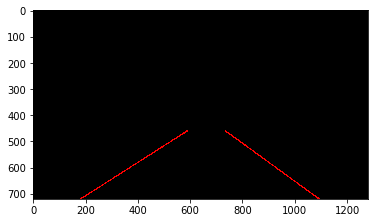

In [24]:
extrapolated_lines_image = np.copy(image)*0
for line in lines:
    cv2.line(extrapolated_lines_image, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])),[255,0,0], 4) 
plt.imshow(extrapolated_lines_image)    

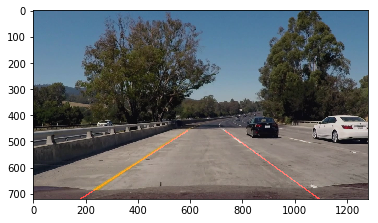

In [25]:
α=0.8 
β=10.0
γ=10
final_image = weighted_img(extrapolated_lines_image,image1,α,β,γ)
plt.imshow(final_image)